<font size=6>**Deep Learning - Workshop: Diffusion Models**</font>


<font size=4>IMPORTANT: Don't forget to activate GPU!</font>

# POV: You need to model a distribution!

Let's suppose we are given some [unknown] **empirical distribution**, and we need to generate **mock data**.

<div>
   <img src="images/Deep_Learning_W_Diffusion/Generated_Data.png" width="600">
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1.1. The sampling problem.  We need to sample some data (<i>right</i>) based on some empirical distribution (<i>left</i>).<br>
        </center>
    </td>
</tr></table>

<font size=3><u>**Example cases**</u><font>

E.g., you are:

- Running an **expensive simulation** $\rightarrow$ cannot generate _all_ the data analytically

- Dealing with **imbalanced data** $\rightarrow$ need more examples of the minority class

- Assessing **some statistics** $S$ $\rightarrow$ would like to "bootstrap" to obtain a distribution for $S$

<font size=3><u>**In-class discussion**</u><font>

What would you do, if you had to sample _pseudo_-real data given a dataset?
    
_Discuss a few mins with your teammate, then report.  This of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
E.g. <b>KDE</b> (<b>Kernel Density Estimation</b>)
<br>
<code>sklearn.neighbors.KernelDensity</code>

We can think of KDE as a **smoothed distribution** (e.g. via Gaussians) of the data.    

<div>
   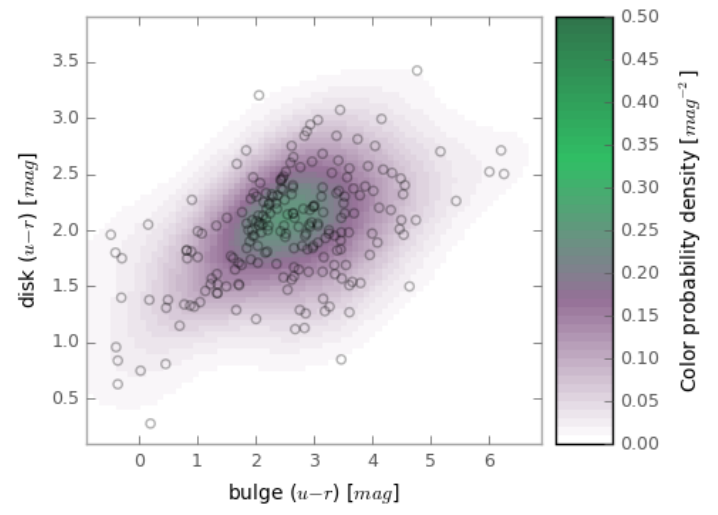
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1b. An example of Kernel Density Estimation applied to a 2D color-color distribution.<br>
            (From <a herf="https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3831B/abstract">Bonfini et al. (2021)</a>)
        </center>
    </td>
</tr></table>

$\rightarrow$ From this **continuous** distribution we can now sample new datasets.
    
<b>PROS</b>:<br>
- Intuitive<br>
- Computationally quick
    
<b>CONS:</b><br>
- Needs parameter tuning (_kernel width_)
- Same global smoothing all over the feature ranges
</details>

- - -
    
In general, a powerful, generalizable model would:
    
- not have **parameters defined ad-hoc** (_parametric models are difficult to define for complex distributions_)
- accounting implicitly for **correlations between features**  
- **adaptable** to the local sub-distribution densities
- **unsupervised**

$\rightarrow$ e.g., **Generative Models**    

## Generative Models $vs$ Discriminative Models

What are **Generative Models**? $\rightarrow$ Best understood when defined in contrast to **Discriminative Models**.

<div>
   <img src="images/Deep_Learning_W_Diffusion/Discriminative_vs_Generative.png" width="800">
</div>

<table><tr>
    <td width=800>
        <center>
            <br>
            Figure 1.2. Summary comparison of Discriminative (<i>left</i>) $vs$ Generative (<i>right</i>) Models.<br>
            (From <a href=https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning>here</a>)
        </center>
    </td>
</tr></table>

A new paradigm to catalog ML models $\rightarrow$ they can be distinguished based on <u>which probability distribution they target</u>.
 
**Discriminative Models**
- **Objective** $\rightarrow$ Differenciate between sample labels
- **Method** $\rightarrow$ Learn the conditional probability $P(y | X)$

        "How likely is this label?"

**Generative Models**
- **Objective** $\rightarrow$ Create new samples
- **Method** $\rightarrow$ Learn the joint probability $P(X, y)$ $-$ or just $P(X)$ if unsupervised
    
        "How likely is this sample, or this <sample, label> pair?"

See this [Google Developers post](https://developers.google.com/machine-learning/gan/generative) for a smooth intro.

# Diffusion models

- Fancy image generator

- astro: https://github.com/smith42/astroddpm

- Theory from 2D example

# Building a diffusion model

This example has been coded based on [this example](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da) by J. Rafid Siddiqui. 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
import torch
import os

from src.helper_plot import hdr_plot_style
from src.utils import * 

path_results = "images/Deep_Learning_W_Diffusion"
if not os.path.exists(path_results):
    os.makedirs(path_results)

In [2]:
force_cpu = False
# to force-use CPU (debug purposes)
if force_cpu:
    device = torch.device('cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Automatically move all tensors to the device:
    torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

print('Device in use [cpu/cuda]:', device)

Device in use [cpu/cuda]: cuda


## Importing Data


In [3]:
import os
import wget
import pandas as pd

path_data = './data/Deep_Learning_W_Diffusion'
# path of data folder

path_to_data = path_data+"/BPT_emlines.csv"
# path/to/file to be created

# > BPT_emlines.csv
link_data = "https://drive.google.com/uc?id=1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek"
#
# Original link: https://drive.google.com/file/d/1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek/view?usp=share_link
# - replace: "file/d/" with "uc?id="
# - remove: "/view?usp=share_link"

if not os.path.exists(path_data):
    os.makedirs(path_data)

if not os.path.exists(path_to_data):
    response = wget.download(link_data, path_to_data)

df_data = pd.read_csv(path_to_data)

# Limiting data:
#n_samples = 10000
#df_data = df_data.sample(n=n_samples, random_state=42)
frac_sampling = 0.02
df_data = df_data.groupby('Target_class', group_keys=False).apply(lambda x: x.sample(frac=frac_sampling))
# stratified sampling

display(df_data.head(5))
print(df_data.shape)

features = ['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']
# x-axis and y-axis features in the BPT diagram
print('Features used in this exercise:', features)

log_sqred_OIII_5007_EQW   D4000_N  log(OIII_5007/H_BETA)  \
14993                 2.223284  1.537336               0.845394   
38874                 1.879197  1.588128               0.712417   
35608                 2.753504  1.214244               0.447986   
39189                 1.903611  1.656605               0.707561   
25750                 3.393228  1.181553               0.459149   

       log(NII_6584/H_ALPHA) Target_class  
14993               0.218588          AGN  
38874               0.004773          AGN  
35608              -0.527598          AGN  
39189               0.070402          AGN  
25750              -0.429216          AGN

(906, 5)
Features used in this exercise: ['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']


## Visualizing data

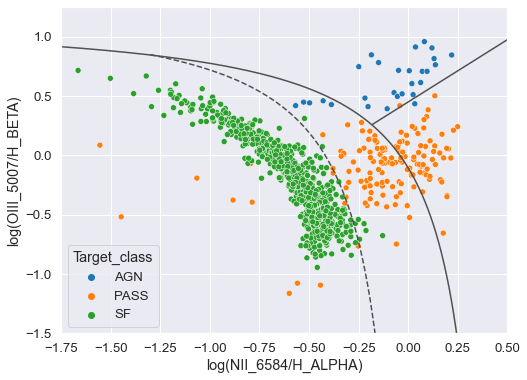

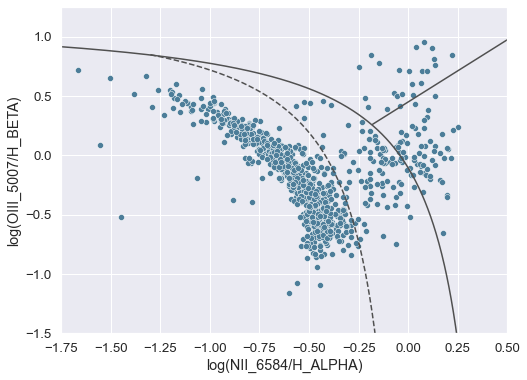

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

# Global Seaborn setup for the reminder of the notebook:
sns.set(font_scale=1.2)

def plot_data(df_data, features, show_classes=True, display=True, ax=None, color=None):
    
    color_codes_wanted = ['grey', 'green', 'purple']

    if color is None:
        palette = ["#4c7d99"]
        color_codes = ['thiscolor']
    else:
        palette = [color]
        color_codes = ['thiscolor']
    c = lambda x: palette[color_codes.index(x)]

    
    if display:
        plt.figure(figsize=(8, 6))

    if show_classes:
        if ax is not None:
            ax = sns.scatterplot(data=df_data, x=features[0], y=features[1],
                        hue='Target_class', palette='tab10', ax=ax)  
        else:
            ax = sns.scatterplot(data=df_data, x=features[0], y=features[1],
                        hue='Target_class', palette='tab10')
    else:
        if ax is not None:
            ax = sns.scatterplot(data=df_data, x=features[0], y=features[1], ax=ax, color=c('thiscolor'))
        else:
            ax = sns.scatterplot(data=df_data, x=features[0], y=features[1], color=c('thiscolor'))
            
    # Kewley+01:
    xx_Ke = np.linspace(-2.5, 0.3, 1000)
    yy_Ke = (0.61/( xx_Ke  - 0.47  )) + 1.19

    # Schawinski+07:
    xx_Sc = np.linspace(-0.180, 1.5, 1000)
    yy_Sc = 1.05*xx_Sc + 0.45

    # Kauffmann+03:
    xx_Ka = np.linspace(-1.3, 0., 1000)
    yy_Ka = 0.61/(xx_Ka -0.05) + 1.3

    if ax is not None:
        ax.plot(xx_Ke, yy_Ke, '-' , color='#505050') # Kewley+01
        ax.plot(xx_Sc, yy_Sc, '-',  color='#505050') # Schawinski+07
        ax.plot(xx_Ka, yy_Ka, '--', color='#505050') # Kauffmann+03     

        ax.set_ylim(-1.5,1.25)
        ax.set_xlim(-1.75,0.5)
    else:
        plt.plot(xx_Ke, yy_Ke, '-' , color='#505050') # Kewley+01
        plt.plot(xx_Sc, yy_Sc, '-',  color='#505050') # Schawinski+07
        plt.plot(xx_Ka, yy_Ka, '--', color='#505050') # Kauffmann+03     
        
        plt.ylim(-1.5,1.25)
        plt.xlim(-1.75,0.5)
    
    if display:
        plt.show()
    
plot_data(df_data, features, show_classes=True)
plot_data(df_data, features, show_classes=False)

## Splitting

_You know the drill ..._

In [5]:
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable

df_X_train, df_X_valid, df_y_train, df_y_valid = \
    train_test_split(df_data[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']],
                     df_data['Target_class'], test_size=0.3, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['set', 'X', 'y']
table.add_row(['train',   np.shape(df_X_train), np.shape(df_y_train)])
table.add_row(['valid', np.shape(df_X_valid), np.shape(df_y_valid)])
print(table)

+---------------------------+
|         Data shape        |
+-------+----------+--------+
|  set  |    X     |   y    |
+-------+----------+--------+
| train | (634, 2) | (634,) |
| valid | (272, 2) | (272,) |
+-------+----------+--------+


## Scaling

In [6]:
# Scaling:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_X_train_n = df_X_train.copy()
df_X_valid_n = df_X_valid.copy()

df_X_train_n[features] = scaler.fit_transform(df_X_train_n[features])
df_X_valid_n[features] = scaler.transform(df_X_valid_n[features])

display(df_X_train.head(3))
display(df_X_train_n.head(3))

log(NII_6584/H_ALPHA)  log(OIII_5007/H_BETA)
5080               -1.155233               0.504463
15241              -0.739187               0.005924
14316              -0.574658              -0.296667

log(NII_6584/H_ALPHA)  log(OIII_5007/H_BETA)
5080               -2.166175               1.812603
15241              -0.782207               0.432140
14316              -0.234906              -0.405741

In [7]:
df_X_train

log(NII_6584/H_ALPHA)  log(OIII_5007/H_BETA)
5080               -1.155233               0.504463
15241              -0.739187               0.005924
14316              -0.574658              -0.296667
16545              -0.739273               0.189197
30547              -0.827998               0.171448
...                      ...                    ...
6848               -0.193054              -0.149174
39084              -0.532009               0.009603
5561               -0.649095              -0.030795
39220              -0.550913              -0.341068
3908               -0.060711               0.072341

[634 rows x 2 columns]

Scaled data (obviously they don't fit in the plot, but we don't care)


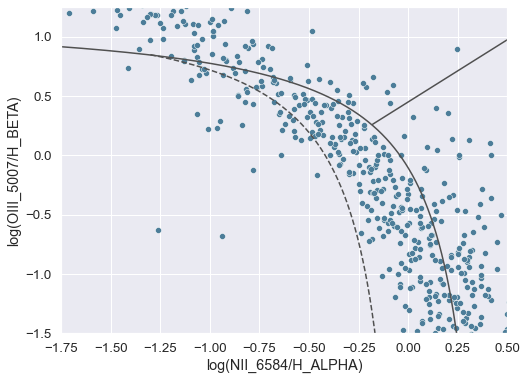

In [8]:
print("Scaled data (obviously they don't fit in the plot, but we don't care)")
plot_data(df_X_train_n, features, show_classes=False)

In [9]:
# Converting to torch tensors:
X_train = torch.tensor(df_X_train_n[features].values).to(torch.float32)
X_valid = torch.tensor(df_X_valid_n[features].values).to(torch.float32)

n_features = np.shape(X_train)[1]
print('Number of features:', n_features)

Number of features: 2


## Diffusion Parameters

In [10]:
n_timesteps = 100
# number of timesteps of the diffusion procedure
# WARNING: Do not increase much beyond 100 or it will saturate the RAM

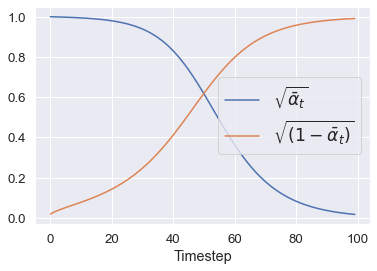

In [11]:
# Beta schedule:
#betas = torch.tensor([1.7e-5] * n_timesteps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_timesteps, start=0.0004, end=0.15)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

from matplotlib import pyplot as plt

if device.type == 'cuda':
    alphas_bar_sqrt_ = alphas_bar_sqrt.detach().cpu().numpy()
else:
    alphas_bar_sqrt_ = alphas_bar_sqrt

plt.plot(alphas_bar_sqrt_, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - alphas_bar_sqrt_) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.xlabel('Timestep')
plt.legend(fontsize="large");

## Forward Diffusion

In [12]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

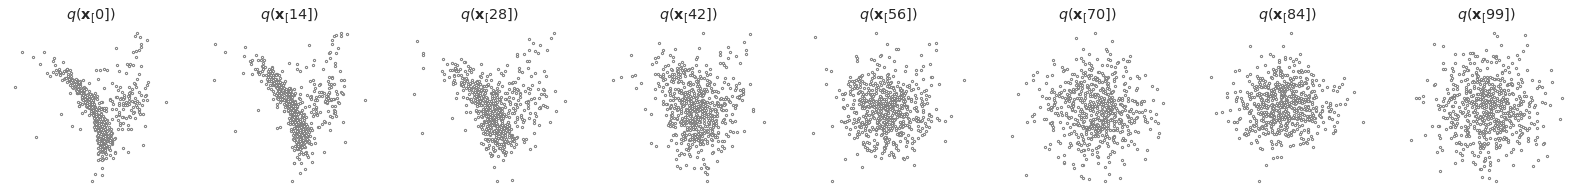

In [13]:
n_plots = 8
fig, axs = plt.subplots(1, n_plots, figsize=(28, 3))

for i, t in enumerate(np.linspace(0, n_timesteps-1, n_plots)):
    t = torch.tensor([int(t)])
    q_t = q_x(X_train, t)
    axs[i].scatter(q_t[:, 0].cpu(), q_t[:, 1].cpu(),color='white',edgecolor='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_'+str(t.cpu().numpy())+')$')

In [14]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

## Reverse Diffusion/Reconstruction

Unlike the forward diffusion, the reverse diffusion process requires training of a neural network model. We setup the necessary loss functions and training parameters and then perform the training.

In [15]:
batch_size = 128

n_epochs = 1000
# training epochs
# NOTE: At every batch of every epoch, a different time step is sampled

Epoch: 0   [/1000] | Loss: 1.0580108


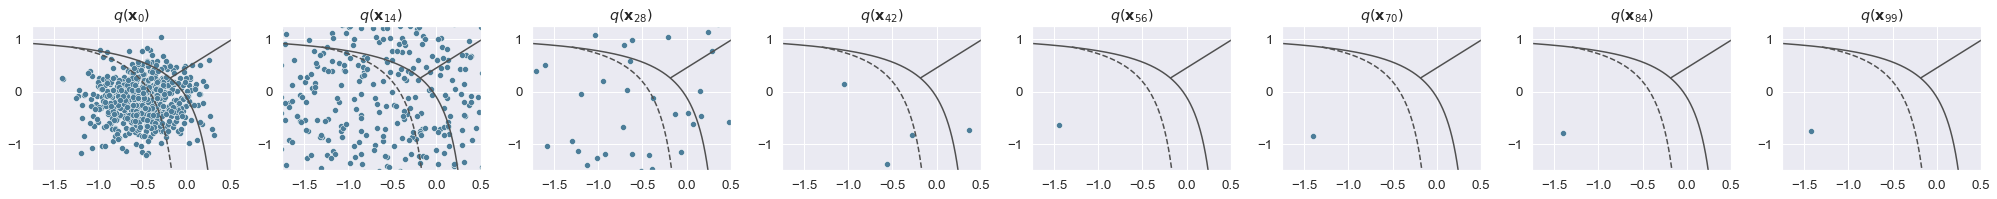

Epoch: 100 [/1000] | Loss: 0.43686855


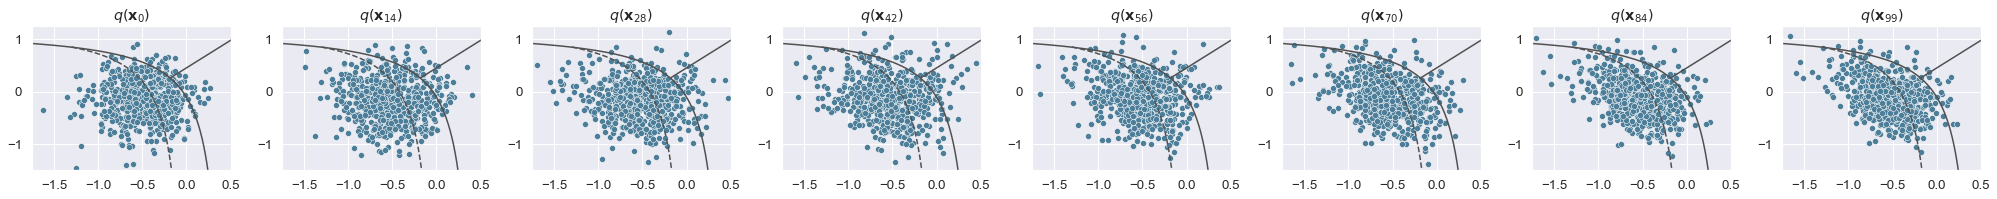

Epoch: 200 [/1000] | Loss: 0.47851792


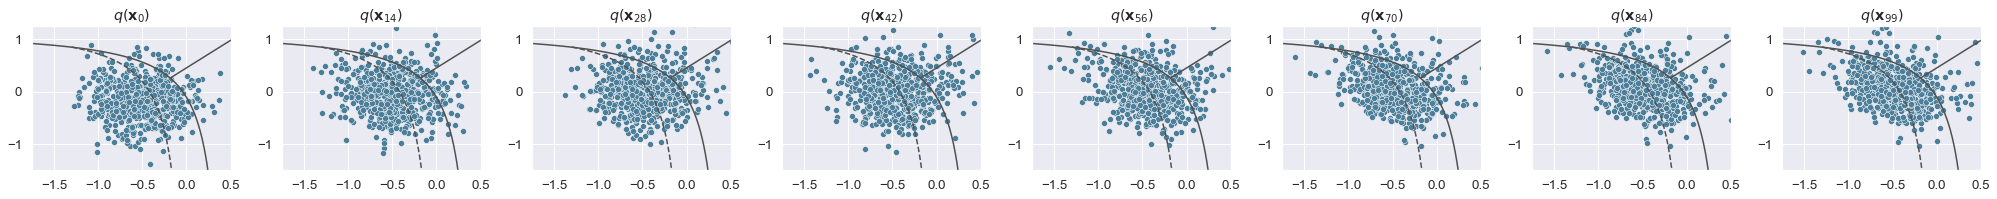

Epoch: 300 [/1000] | Loss: 0.48535568


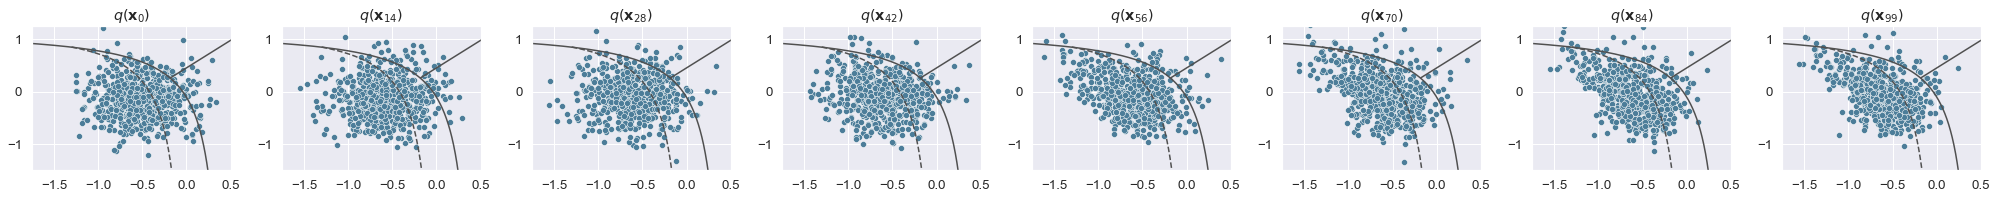

Epoch: 400 [/1000] | Loss: 0.44615746


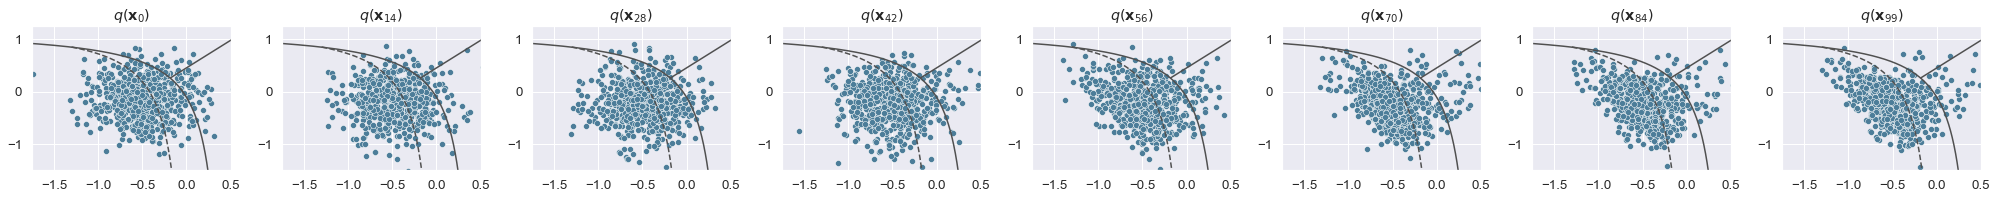

Epoch: 500 [/1000] | Loss: 0.3693024


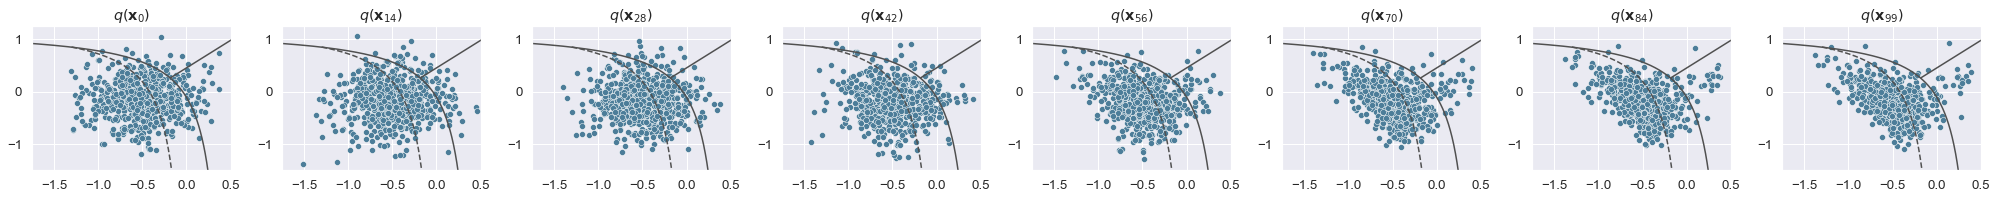

Epoch: 600 [/1000] | Loss: 0.42997086


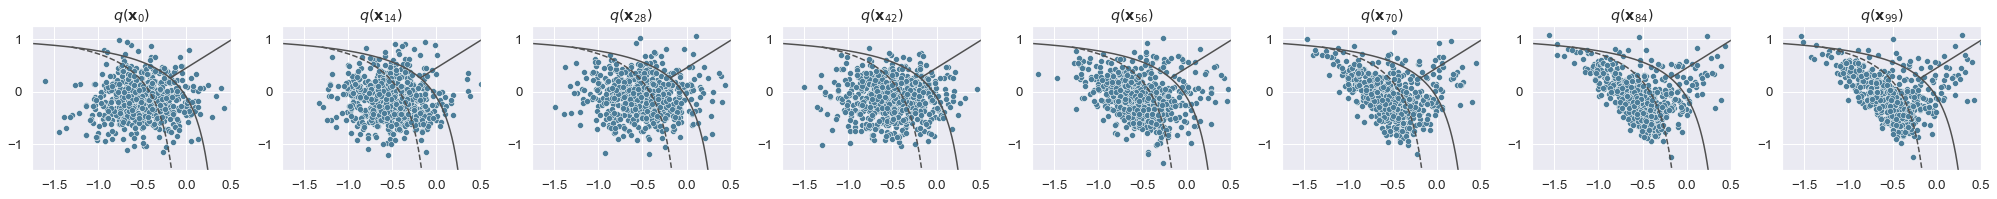

Epoch: 700 [/1000] | Loss: 0.31841388


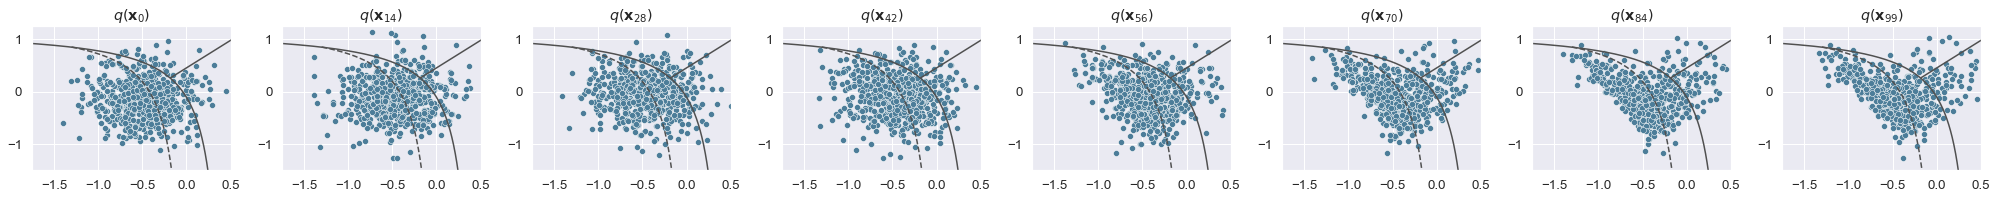

Epoch: 800 [/1000] | Loss: 0.41908956


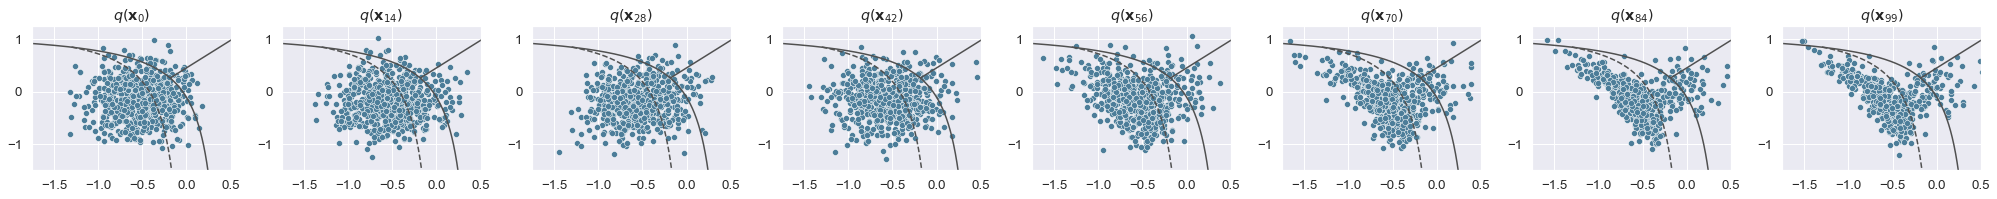

Epoch: 900 [/1000] | Loss: 0.38201684


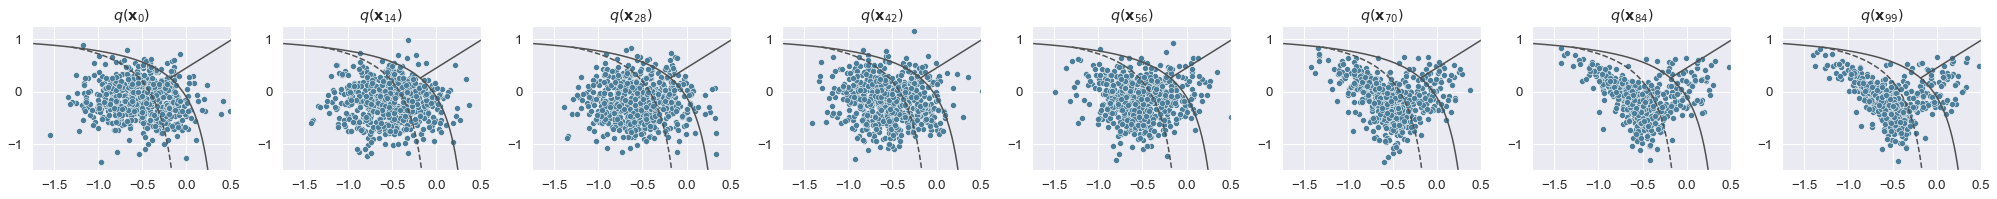

CPU times: user 34.7 s, sys: 1.34 s, total: 36 s
Wall time: 34.2 s


In [16]:
%%time
from src.model import ConditionalModel
from src.ema import EMA
import torch.optim as optim

model = ConditionalModel(n_timesteps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model (a finesse - read here: https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage)
ema = EMA(0.9)
ema.register(model)

losses = {'train':[], 'valid':[]}

for epoch in range(n_epochs):
    permutation = torch.randperm(X_train.size()[0])
    # random permutations of the batch indexes
    for i in range(0, X_train.size()[0], batch_size):
        # Retrieving current batch:
        indices = permutation[i:i+batch_size]
        batch_x = X_train[indices]
        batch_size_ = len(batch_x)
        # calculating actual size since the last batch can be smaller than <batch_size>
        
        # Selecting a random timestep:
        t = torch.randint(0, n_timesteps, size=(batch_size_,))
        
        # Sampling noise (first term in Equation 14) -------------------------
        e = torch.randn_like(batch_x)
        #---------------------------------------------------------------------

        # Predicting noise using NN (second term in Equation 14) -------------
        # - The "extract" calls are just convenience functions which pick a
        #    value of the alphas at time <t> and reshape it to the batch size
        # - The core of the prediction is where "model" is called 
        #
        # Multiplier of x_0 in the Equation:
        alpha_bar_sqrt = extract(alphas_bar_sqrt, t, batch_x)
        # Multiplier of epsilon in the Equation:
        one_minus_alpha_bar_sqrt = extract(one_minus_alphas_bar_sqrt, t, batch_x)
        # Model input:
        input_e = batch_x * alpha_bar_sqrt + one_minus_alpha_bar_sqrt*e
        # Model prediction:
        e_theta = model(input_e, t)
        #---------------------------------------------------------------------
        
        # Equation 14:
        loss = (e - e_theta).square().mean()

        # Optimizing the NN --------------------------------------------------
        # Before the backward pass, zero-ing all the network gradients:
        optimizer.zero_grad()
        # Backward pass: computing gradient of the loss with respect to parameters
        loss.backward()
        # Performing gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters:
        optimizer.step()
        # Updating the exponential moving average:
        ema.update(model)
        #---------------------------------------------------------------------

    ###############################################
    # Done! The rest is just to display stuff ... #
    ###############################################

    # Printing loss (every 1/10th of the total epochs):
    if (epoch % int(n_epochs/10) == 0):       
        print('Epoch: %-3s [/%3s] | Loss: %s' % (epoch, n_epochs, loss.detach().cpu().numpy()))

    # Plotting data (every 1/10th of the total epochs):
    if (epoch % int(n_epochs/10) == 0):       
        
        # Generating a whole NEW time sequence by drawing from the learnt distribution:
        x_seq_gen = p_sample_loop(model, X_train.shape, n_timesteps,
                                  alphas,betas, one_minus_alphas_bar_sqrt)
        
        # Looping through all timesteps for this epoch, and plotting a few of them:
        n_plots = 8
        fig, axs = plt.subplots(1, n_plots, figsize=(28, 3))
        for j, t in enumerate(np.linspace(0, n_timesteps-1, n_plots)):
            t = int(t)
            # Picking dataset generated for timestep <t>:
            x_t_gen = x_seq_gen[t]
            if device != 'cpu': x_t_gen = x_t_gen.detach().cpu().numpy()            
            # Reverting normalization:
            df_data_gen = pd.DataFrame(data=x_t_gen, columns=features)
            df_data_gen[features] = scaler.inverse_transform(df_data_gen[features])
            # Plotting:
            plot_data(df_data_gen, features, show_classes=False, display=False, ax=axs[j])
            axs[j].xaxis.label.set_visible(False) 
            axs[j].yaxis.label.set_visible(False) 
            axs[j].set_title('$q(\mathbf{x}_{'+str(t)+'})$')
        plt.tight_layout()
        plt.show()

    # Storing loss:
    losses['train'].append(loss)  

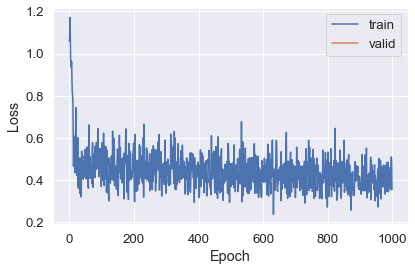

In [17]:
# Plotting the Loss:
import matplotlib.pyplot as plt

if device != 'cpu':
    losses_train = [loss.detach().cpu().numpy() for loss in losses['train']]
    losses_valid = [loss.detach().cpu().numpy() for loss in losses['valid']]

fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes
ax.plot(losses_train, label='train')
ax.plot(losses_valid, label='valid')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.tight_layout()
plt.show() 

## Animation

_You don't need to care about the following code, it is only for presentation purposes!_

We will create an **image sequence** that resembles the evolution of the data along the timesteps, both in the **forward** (diffusion) and in the **backward** (denoising) pass.

In the GIF:
- we first diffuse the **original** data
- we then start from **random noise** and converge towards the **sampled** distribution

IMPORTANT: _Notice that those are two different datasets! The first is the training dataset being diffused, the second is a new dataset randomly sampled (from noise) and inverse-diffused!_

_I.e., the start of the inverse-diffusion is <u>not</u> the end-point of the diffusion!  This is the whole point of learning the distribution $-$ we want to sample <u>new</u> data!_

_They sequences are just collated together to display the intuition behind the process._

In [18]:
import matplotlib
from matplotlib.colors import to_hex
import io
from PIL import Image
from tqdm import tqdm

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["tomato","teal","steelblue"])

### Generating the diffusion image sequence

100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


CPU times: user 14.4 s, sys: 271 ms, total: 14.7 s
Wall time: 14.6 s


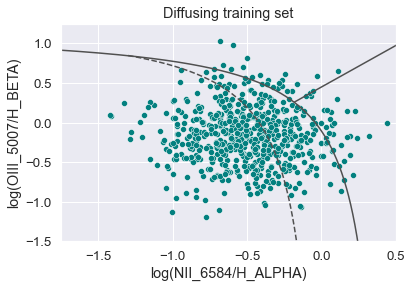

In [19]:
%%time
    
imgs_diffusion = []

pbar = tqdm(range(n_timesteps))
for t in pbar:
    plt.clf()
    q_x_t = q_x(X_train, torch.tensor([t]))
    if device != 'cpu': q_x_t = q_x_t.detach().cpu().numpy()

    # Indexing colors using first-half palette (the rest is used for the de-noising!):
    color = to_hex(cmap(t/n_timesteps/2))

    # Reverting normalization:
    df_data_noise = pd.DataFrame(data=q_x_t, columns=features)
    df_data_noise[features] = scaler.inverse_transform(df_data_noise[features])
    # Plotting:
    plt.title('Diffusing training set')
    plot_data(df_data_noise, features, show_classes=False, display=False, color=color)

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs_diffusion.append(img)

### Generating the de-noising [reverse] image sequence

Let's generate a brand new dataset composed of `n_samples_gen` samples!

100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


CPU times: user 15.5 s, sys: 268 ms, total: 15.8 s
Wall time: 15.7 s


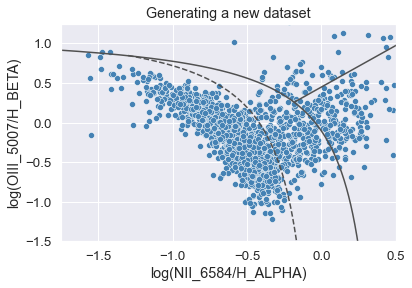

In [20]:
%%time

imgs_inv_diffusion = []

# Generating a whole NEW time sequence by drawing from the learnt distribution:
n_samples_gen = 2000
X_gen_shape = (n_samples_gen, X_train.shape[1])
x_seq_gen = p_sample_loop(model, X_gen_shape, n_timesteps,
                          alphas,betas, one_minus_alphas_bar_sqrt)

pbar = tqdm(range(n_timesteps))
for t in pbar: 
    plt.clf()
    # Picking dataset generated for timestep <t>:
    x_t_gen = x_seq_gen[t]
    if device != 'cpu': x_t_gen = x_t_gen.detach().cpu().numpy() 

    # Indexing colors using second-half palette (the rest is used for the noising!):
    color = to_hex(cmap(t/n_timesteps/2+0.5))

    # Reverting normalization:
    df_data_gen = pd.DataFrame(data=x_t_gen, columns=features)
    df_data_gen[features] = scaler.inverse_transform(df_data_gen[features])
    # Plotting:
    plt.title('Generating a new dataset')
    plot_data(df_data_gen, features, show_classes=False, display=False, color=color)
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs_inv_diffusion.append(img)    

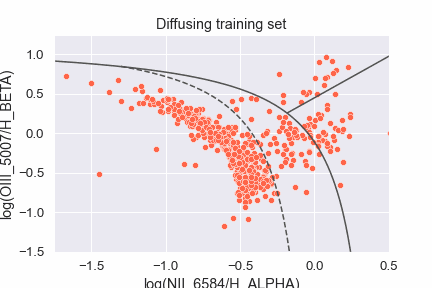

In [21]:
# Pasting the 2 sequnces into a sequential GIF animation:
imgs_timeline = imgs_diffusion + imgs_inv_diffusion

imgs_timeline[0].save(path_results+'/diffusion.gif', format='GIF', append_images=imgs_timeline,
             save_all=True, duration=50, loop=0)

import IPython

def show_image(filename):
    with open(filename, 'rb') as f:
        img = f.read()
    IPython.display.display(IPython.display.Image(data=img, format='gif'))

show_image(path_results+'/diffusion.gif')

## Measure K-L

sklearn.metrics.mutual_info_score([0,1],[1,0])

# References

[1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. arXiv preprint arXiv:2006.11239.

[2] Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.

In [ ]:
###EOF

In [ ]:
###EOF